In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import sounddevice as sd

In [2]:
import matplotlib.pyplot as plt
from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import models


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
sources = ["acoustic", "electronic", "synthetic"]
families = ["bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "synth_lead", "vocal"]

In [5]:
spectrograms_train = tf.saved_model.load("data/processed/spectrograms_train").read_value()
spectrograms_test = tf.saved_model.load("data/processed/spectrograms_test").read_value()
labels_train = tf.saved_model.load("data/processed/labels_train").read_value()
labels_test = tf.saved_model.load("data/processed/labels_test").read_value()

In [6]:
audio_train = tf.saved_model.load("data/processed/audio_train").read_value()
audio_test = tf.saved_model.load("data/processed/audio_test").read_value()

In [6]:
print(spectrograms_train.shape)
print(labels_train.shape)
print(spectrograms_test.shape)
print(labels_test.shape)
# print(audio_train.shape)
# print(audio_test.shape)

(3072, 499, 129, 1)
(3072,)
(1024, 499, 129, 1)
(1024,)


In [19]:
input_shape = spectrograms_train.shape[1:-1]
print('Input shape:', input_shape)
num_labels = len(sources)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrograms_train)

model = models.Sequential([
    layers.Input(shape=(None, None, 1)),
    # Downsample the input.
    layers.Resizing(499, 129),
    # Normalize.
    norm_layer,
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])
model.summary()

Input shape: (499, 129)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_4 (Resizing)       (None, 499, 129, 1)       0         
                                                                 
 normalization_4 (Normalizat  (None, 499, 129, 1)      3         
 ion)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 497, 127, 16)      160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 248, 63, 16)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 246, 61, 32)       4640      
                                                                 
 max_pooling2d_7 (MaxPooling  

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [21]:
EPOCHS = 50
history = model.fit(
    x=spectrograms_train,
    y=labels_train,
    validation_data=(spectrograms_test, labels_test),
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/50
96/96 [==============================] - 6s 49ms/step - loss: 1.0037 - accuracy: 0.5296 - val_loss: 0.8134 - val_accuracy: 0.6201
Epoch 2/50
96/96 [==============================] - 5s 47ms/step - loss: 0.7179 - accuracy: 0.6715 - val_loss: 0.5351 - val_accuracy: 0.7617
Epoch 3/50
96/96 [==============================] - 5s 47ms/step - loss: 0.5209 - accuracy: 0.7715 - val_loss: 0.4095 - val_accuracy: 0.8369
Epoch 4/50
96/96 [==============================] - 5s 48ms/step - loss: 0.4159 - accuracy: 0.8320 - val_loss: 0.3283 - val_accuracy: 0.8809
Epoch 5/50
96/96 [==============================] - 5s 48ms/step - loss: 0.3249 - accuracy: 0.8737 - val_loss: 0.2377 - val_accuracy: 0.9258
Epoch 6/50
96/96 [==============================] - 5s 48ms/step - loss: 0.2487 - accuracy: 0.9082 - val_loss: 0.2186 - val_accuracy: 0.9229
Epoch 7/50
96/96 [==============================] - 5s 48ms/step - loss: 0.2155 - accuracy: 0.9248 - val_loss: 0.1365 - val_accuracy: 0.9600
Epoch 8/50
96

Text(0, 0.5, 'Accuracy [%]')

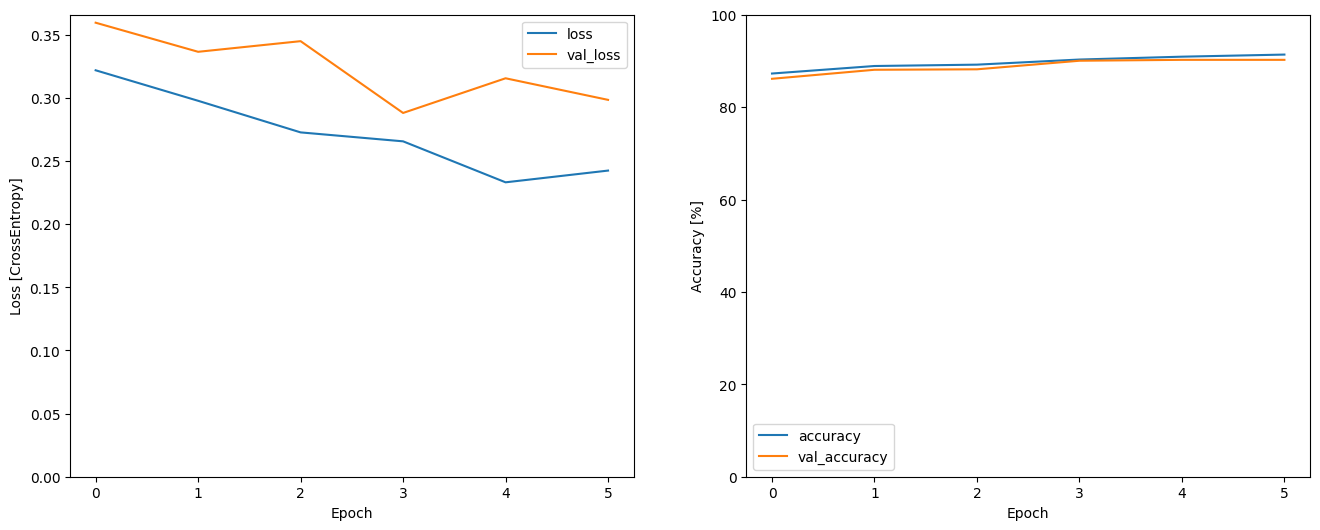

In [59]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [11]:
model.save("./models/source_classifier_cnn")

INFO:tensorflow:Assets written to: ./models/source_classifier_cnn\assets


INFO:tensorflow:Assets written to: ./models/source_classifier_cnn\assets


In [61]:
model = tf.keras.models.load_model("./models/model1")

In [66]:
x = tf.io.read_file("./samples/piano-G3.wav")
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

In [67]:
prediction = model(x)

In [68]:
prediction

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.860001  ,  0.1342126 , -0.85429704]], dtype=float32)>

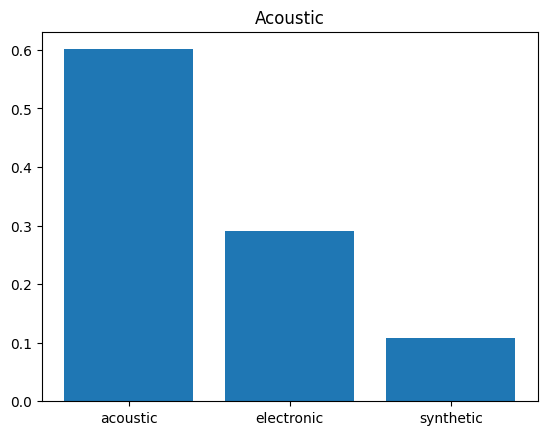

In [69]:
plt.bar(sources, tf.nn.softmax(prediction[0]))
plt.title('Acoustic')
plt.show()

display.display(display.Audio(waveform, rate=16000))